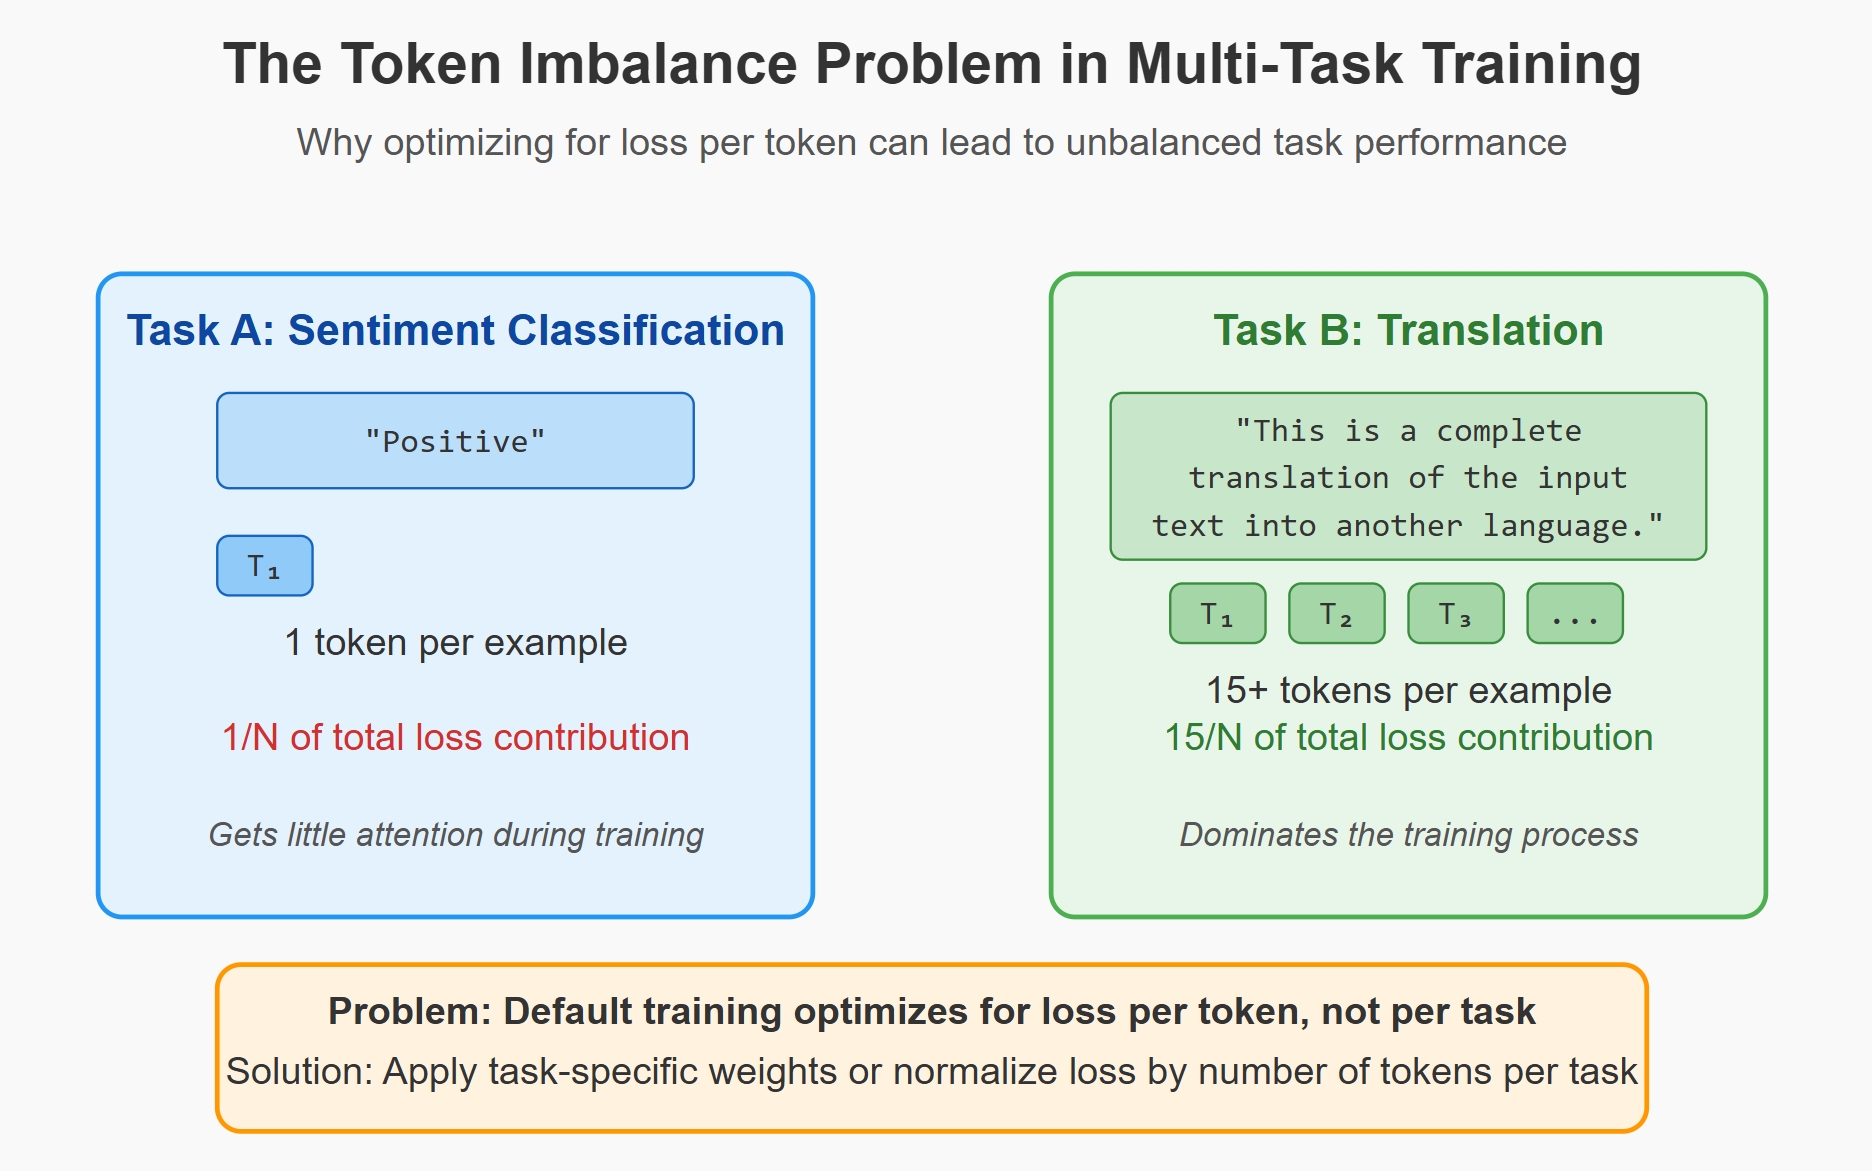

In [1]:
from IPython.display import display, Image
# Display an image from a file path
display(Image("../input/diagrams/mt.png"))

In [2]:
!pip install -U trl bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 6.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 22.3 MB/s eta 0:00:00:00:0100:01


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("Nassouf")

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, concatenate_datasets, Dataset, Value
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
import torch.nn.utils.prune as prune
from transformers import AdamW, get_linear_schedule_with_warmup

### Define reusable functions for dataset loading and processing

In [5]:
def load_dataset_by_tag(dataset_type, tag, split='train'):
    return load_dataset(f"{dataset_type}{tag}", split=split)

def load_and_combine_datasets(tag, split='train'):
    """
    Load and combine multiple datasets with all unique columns (union).
    Empty strings are used for missing values.
    
    Args:
        tag (str): Tag for the datasets (Train, Test)
        split (str): Split to load (train, test)
        
    Returns:
        Dataset: Combined dataset with all unique columns
    """
    # Load datasets with the given split
    se_dataset = load_dataset_by_tag("lelapa/Sentiment", tag, split)
    mt_dataset = load_dataset_by_tag("lelapa/MT", tag, split)
    xn_dataset = load_dataset_by_tag("lelapa/XNLI", tag, split)

    # Identify all unique columns (union)
    all_columns = list(set(se_dataset.column_names) | 
                      set(mt_dataset.column_names) | 
                      set(xn_dataset.column_names))
    print(f"All Columns: {all_columns}")

    # Function to ensure dataset has all columns, filling missing ones with empty strings
    def ensure_all_columns(dataset, all_cols):
        # Add each missing column one by one
        for col in all_cols:
            if col not in dataset.column_names:
                # Create array of empty strings with the same length as the dataset
                empty_column = [""] * len(dataset)
                dataset = dataset.add_column(col, empty_column)
        
        return dataset

    # Ensure all datasets have all columns
    se_dataset = ensure_all_columns(se_dataset, all_columns)
    mt_dataset = ensure_all_columns(mt_dataset, all_columns)
    xn_dataset = ensure_all_columns(xn_dataset, all_columns)

    # Make sure 'targets' column is string type if it exists in all datasets
    if "targets" in all_columns:
        se_dataset = se_dataset.cast_column("targets", Value("string"))
        mt_dataset = mt_dataset.cast_column("targets", Value("string"))
        xn_dataset = xn_dataset.cast_column("targets", Value("string"))

    # Concatenate datasets
    combined_dataset = concatenate_datasets([se_dataset, mt_dataset, xn_dataset])

    return combined_dataset


def extract_task_from_id(id_string):
    """
    Extract task type from ID string.
    
    Args:
        id_string (str): ID string containing task information
        
    Returns:
        str: Extracted task type
    """
    task = id_string.split('_')[3]
    # Handle special case for sentiment task
    return 'sentiment' if task == ' dev' else task


def analyze_task_lengths(df, task_column='task'):
    """
    Analyze and display target sequence lengths for each task.
    
    Args:
        df (DataFrame): DataFrame containing task and targets columns
        task_column (str): Name of the task column
        
    Returns:
        dict: Statistics about target lengths per task
    """
    stats = {}
    print("Target sequence length analysis by task:")
    print("="*50)
    
    for task in df[task_column].unique():
        mask = df[task_column] == task
        task_stats = df.loc[mask, 'targets'].apply(lambda x: len(x.split())).describe()
        print(f"Task: {task}")
        print(task_stats)
        print("-"*50)
        stats[task] = task_stats
    
    return stats


def balance_target_lengths(df, task_column='task', reference_task='mt', repetition_factor=11):
    """
    Balance target sequence lengths by repeating shorter targets.
    
    Args:
        df (DataFrame): DataFrame containing task and targets columns
        task_column (str): Name of the task column
        reference_task (str): Task with longer sequences to use as reference
        repetition_factor (int): Number of times to repeat shorter sequences
        
    Returns:
        DataFrame: DataFrame with balanced target lengths
    """
    df_balanced = df.copy()
    
    for task in df_balanced[task_column].unique():
        if task != reference_task:
            mask = df_balanced[task_column] == task
            df_balanced.loc[mask, 'targets'] = df_balanced.loc[mask, 'targets'].apply(
                lambda x: ' '.join([x] * repetition_factor)
            )
    
    return df_balanced


def plot_target_lengths(df_before, df_after, task_column='task'):
    """
    Plot target lengths before and after balancing.
    
    Args:
        df_before (DataFrame): DataFrame before balancing
        df_after (DataFrame): DataFrame after balancing
        task_column (str): Name of the task column
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Before balancing
    task_stats_before = {}
    for task in df_before[task_column].unique():
        mask = df_before[task_column] == task
        lengths = df_before.loc[mask, 'targets'].apply(lambda x: len(x.split()))
        task_stats_before[task] = lengths.mean()
    
    # After balancing
    task_stats_after = {}
    for task in df_after[task_column].unique():
        mask = df_after[task_column] == task
        lengths = df_after.loc[mask, 'targets'].apply(lambda x: len(x.split()))
        task_stats_after[task] = lengths.mean()
    
    # Plotting
    ax1.bar(task_stats_before.keys(), task_stats_before.values())
    ax1.set_title('Average Target Length Before Balancing')
    ax1.set_ylabel('Average number of tokens')
    
    ax2.bar(task_stats_after.keys(), task_stats_after.values())
    ax2.set_title('Average Target Length After Balancing')
    
    plt.tight_layout()
    #plt.savefig('target_length_comparison.png')
    plt.show()
    #plt.close()


def formatting_prompts_func(example):
    """
    Format examples for instruction tuning.
    
    Args:
        example (dict): Example containing instruction, inputs, and targets
        
    Returns:
        str: Formatted prompt
    """
    premise = example['premise']
    premise = premise+'\n' if len(premise) else ''
    if example['targets'] is not None:
        return f"### Instruction: {example['instruction']}\n### Input: {premise}{example['inputs']}\n### Response: {example['targets']}"
    return f"### Instruction: {example['instruction']}\n### Input: {premise}{example['inputs']}\n### Response:"
def apply_pruning(model, amount=0.15, prune_type="l1"):
    """
    Apply unstructured pruning to all Linear layers in the model.   
    Args:
        model: The model to prune.
        amount (float): Fraction of weights to prune in each linear layer.
        prune_type (str): Type of unstructured pruning - "l1" (L1 norm) or "random".    
    Returns:
        The pruned model.
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            if prune_type == "l1":
                # Unstructured pruning based on L1 norm (removes smallest magnitude weights)
                prune.l1_unstructured(module, name="weight", amount=amount)
            elif prune_type == "random":
                # Random unstructured pruning (removes random weights)
                prune.random_unstructured(module, name="weight", amount=amount)
            else:
                raise ValueError("Invalid prune_type. Choose 'l1' or 'random'.")
            # Make pruning permanent
            prune.remove(module, "weight")    
    return model


def setup_model_and_tokenizer(model_name, use_4bit=True,use_prune=False):
    """
    Set up model and tokenizer for QLoRA fine-tuning.
    
    Args:
        model_name (str): Name of the base model
        use_4bit (bool): Whether to use 4-bit quantization
        
    Returns:
        tuple: (model, tokenizer, bnb_config)
    """
    # Define BitsAndBytes config for quantization
    if use_4bit:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
        )
    else:
        bnb_config = None
    
    # Load model with quantization config
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        token=token,
    )
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
    tokenizer.pad_token = tokenizer.eos_token
    if use_prune:
        model = apply_pruning(model)
    
    return model, tokenizer, bnb_config


def apply_lora_adapters(model, r=8, lora_alpha=16, dropout=0.05):
    """
    Apply LoRA adapters to the model.
    
    Args:
        model: Base model
        r (int): LoRA rank
        lora_alpha (int): LoRA alpha parameter
        dropout (float): Dropout probability
        
    Returns:
        model: Model with LoRA adapters
    """
    # Define LoRA Config
    lora_config = LoraConfig(
        r=r,
        lora_alpha=lora_alpha,
        target_modules=["q_proj", "v_proj","k_proj"],
        lora_dropout=dropout,
        bias="none",
        task_type="CAUSAL_LM"
    )
    
    # Apply LoRA adapters to model
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()
    
    return model


def setup_trainer(model, dataset, tokenizer, output_dir, num_epochs=3):
    """
    Set up SFTTrainer for fine-tuning.
    
    Args:
        model: Model with LoRA adapters
        dataset: Training dataset
        tokenizer: Tokenizer
        output_dir (str): Output directory for checkpoints
        num_epochs (int): Number of training epochs
        
    Returns:
        SFTTrainer: Trainer object
    """
    # Define response template for proper label masking
    response_template_with_context = "\n### Response:"
    response_template_ids = tokenizer.encode(response_template_with_context, add_special_tokens=False)[2:]
    
    # Data collator for masked LM training
    collator = DataCollatorForCompletionOnlyLM(response_template_ids, tokenizer=tokenizer)
    
    # Training arguments
    train_args = SFTConfig(
        output_dir=output_dir,
        max_seq_length=512,
        num_train_epochs=num_epochs,
        save_strategy="epoch",
        logging_steps=10,
        save_total_limit=2,
        report_to=[],  # Disable wandb
    )
    
    # Trainer setup
    trainer = SFTTrainer(
        model=model,
        train_dataset=dataset,
        args=train_args,
        formatting_func=formatting_prompts_func,
        data_collator=collator,
    )
    
    return trainer


def generate_response(model, tokenizer, prompt, max_new_tokens=20):
    """
    Generate response using fine-tuned model.
    
    Args:
        model: Fine-tuned model
        tokenizer: Tokenizer
        prompt (str): Input prompt
        max_new_tokens (int): Maximum number of tokens to generate
        
    Returns:
        str: Generated response
    """
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = generated_text[len(prompt):].strip()
    
    return response


def encode_sentiment_label(label):
    """
    Encode sentiment label to integer.
    
    Args:
        label (str): Sentiment label
        
    Returns:
        int: Encoded label
    """
    for c, i in enumerate(["Chanya", "Wastani", "Hasi"]):
        if label == i:
            return c
    for c, i in enumerate(["Kyakkyawa", "Tsaka-tsaki", "Korau"]):
        if label == i:
            return c
    return 0


def apply_inference_to_test_data(model, tokenizer, test_dataset):
    """
    Apply inference to test dataset.
    
    Args:
        model: Fine-tuned model
        tokenizer: Tokenizer
        test_dataset: Test dataset
        
    Returns:
        DataFrame: DataFrame with generated responses
    """
    df = pd.DataFrame(test_dataset)
    model.eval()
    
    # Apply inference with tqdm progress bar
    tqdm.pandas(desc="Generating Responses")
    df['generated'] = df.progress_apply(
        lambda row: generate_response(model, tokenizer, formatting_prompts_func(row)), 
        axis=1
    )
    
    # Process responses based on task type
    df['Response'] = ''
    
    # Sentiment task
    mask = df.ID.apply(lambda x: 'sentiment' in x)
    df.loc[mask, 'Response'] = df.loc[mask, 'generated'].apply(
        lambda x: encode_sentiment_label(x.strip().split()[0])
    )
    
    # XNLI task
    mask = df.ID.apply(lambda x: 'afrixnli' in x)
    df.loc[mask, 'Response'] = df.loc[mask, 'generated'].apply(
        lambda x: int(x.strip().split()[0])%3 if x.strip().split()[0].isdigit() else 0
    )
    
    # MT task
    mask = df.ID.apply(lambda x: 'mt_' in x)
    df.loc[mask, 'Response'] = df.loc[mask, 'generated']
    
    return df

def display_formatted_examples(df, num_examples=2):
    """
    Display formatted examples for each task.
    
    Args:
        df (DataFrame): DataFrame containing the examples
        num_examples (int): Number of examples to display per task
    """
    for task in df.task.unique():
        print(f"\n\n{'='*40}\nTask: {task}\n{'='*40}")
        mask = df.task == task
        for i, (_, row) in enumerate(df[mask].iterrows()):
            if i >= num_examples:
                break
                
            print(f"\nExample {i+1}:")
            print("-" * 40)
            formatted = formatting_prompts_func(row)
            print(formatted)
            print("-" * 40)

### Load and explore the datasets

In [6]:
print("# Loading datasets")
train_dataset = load_and_combine_datasets("Train")
test_dataset = load_and_combine_datasets("Test")

print("\n# Example from training dataset:")
print(train_dataset[0])

print("\n# Example from test dataset:")
print(test_dataset[0])

# Loading datasets


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

All Columns: ['task', 'premise', 'langs', 'instruction', 'data_source', 'ID', 'targets', 'inputs']


Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/486 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/484 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

All Columns: ['task', 'premise', 'langs', 'instruction', 'data_source', 'ID', 'targets', 'inputs']


Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]


# Example from training dataset:
{'ID': 'ID_6aba33a1_sentiment_ dev_hausa', 'task': 'sentiment', 'langs': 'hausa', 'data_source': 'afrisenti', 'instruction': 'Za ka iya tantance yanayin wannan rubutu? Bi waɗannan jagororin sharhi: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.', 'inputs': '@user @user allah ya tsayyaba yar uwa 🎂 😍', 'targets': 'Kyakkyawa', 'premise': ''}

# Example from test dataset:
{'ID': 'ID_f3c74c7b_sentiment_test__hausa', 'task': 'sentiment', 'langs': 'hausa', 'data_source': 'afrisenti', 'instruction': "Gano ra'ayin da aka bayyana a cikin wannan rubutu. Bin waɗannan jagororin, kyakkyawa yana na rubutu na nufin kyakkyawan tunani, ɗabi'a, da motsin rai. Korau na nuna rubutu na nufin mummunan tunani ko motsin rai. Tsaka-tsaki na nuna rubutu baya nufin magana mai kyau ko mara kyau kai tsaye ko a kaikaice.",

Convert dataset to DataFrame for easier processing

In [7]:
print("# Converting to DataFrame and extracting task types")
train_df = train_dataset.to_pandas()
train_df['task'] = train_df.ID.apply(extract_task_from_id)

print("\n# Dataset distribution by task:")
print(train_df.task.value_counts())

# Converting to DataFrame and extracting task types

# Dataset distribution by task:
task
mt           600
sentiment    400
afrixnli     400
Name: count, dtype: int64


In [8]:
display_formatted_examples(train_df)



Task: sentiment

Example 1:
----------------------------------------
### Instruction: Za ka iya tantance yanayin wannan rubutu? Bi waɗannan jagororin sharhi: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.
### Input: @user @user allah ya tsayyaba yar uwa 🎂 😍
### Response: Kyakkyawa
----------------------------------------

Example 2:
----------------------------------------
### Instruction: Da fatan za a gano ra'ayin da ke cikin wannan rubutu bisa ga jagorori masu zuwa: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.
### Input: @user intenet a masallachi😭😭😭 wani salo ne na karkatar da masu ibada zuwa wani abu daban amma a raayina bai da mahimmanchi
### Response: Tsa

Analyze target sequence lengths (without fix)

In [9]:
print("\n# Analyzing target sequence lengths without balancing")
task_stats_before = analyze_task_lengths(train_df)


# Analyzing target sequence lengths without balancing
Target sequence length analysis by task:
Task: sentiment
count    400.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: targets, dtype: float64
--------------------------------------------------
Task: mt
count    600.000000
mean      11.801667
std        8.347163
min        2.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       62.000000
Name: targets, dtype: float64
--------------------------------------------------
Task: afrixnli
count    400.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: targets, dtype: float64
--------------------------------------------------


Create unbalanced dataset for demonstration

In [10]:
unbalanced_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))

print("\n# The problem: Tasks with shorter outputs (like sentiment) will be underrepresented")
print("in the loss function compared to tasks with longer outputs (like mt).")


# The problem: Tasks with shorter outputs (like sentiment) will be underrepresented
in the loss function compared to tasks with longer outputs (like mt).


Apply the fix: balance target lengths across tasks

In [11]:
print("\n# Applying target length balancing fix")
balanced_df = balance_target_lengths(train_df)


# Applying target length balancing fix


In [12]:
display_formatted_examples(balanced_df)



Task: sentiment

Example 1:
----------------------------------------
### Instruction: Za ka iya tantance yanayin wannan rubutu? Bi waɗannan jagororin sharhi: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.
### Input: @user @user allah ya tsayyaba yar uwa 🎂 😍
### Response: Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa
----------------------------------------

Example 2:
----------------------------------------
### Instruction: Da fatan za a gano ra'ayin da ke cikin wannan rubutu bisa ga jagorori masu zuwa: Kyakkyawa: idan rubutu na nuna kyakkyawan tunani, hali, da yanayi. Korau: idan rubutu yana nuna mummunar tunani ko yanayi. Neutral: idan rubutu baya nuna kyakkyawar magana ko mara kyau kai tsaye ko a kaikaice.
### Input: @user intenet a masallachi😭😭😭 wani salo 

In [13]:
import random
import pandas as pd
def sentence_shuffling(sentence):
    words = sentence.split()
    if len(words) < 4:
        return sentence
    part_len = len(words) // 2
    first_part, second_part = words[:part_len], words[part_len:]
    random.shuffle(first_part)
    random.shuffle(second_part)
    return " ".join(first_part + second_part)
def word_duplication(sentence, p=0.1):
    words = sentence.split()
    new_words = []
    for word in words:
        new_words.append(word)
        if random.random() < p:
            new_words.append(word)  # Duplicate word
    return " ".join(new_words)

def random_swap(sentence, n=1):
    """Randomly swaps two words in a sentence n times."""
    words = sentence.split()
    if len(words) < 2:
        return sentence  # No swap possible
    
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    
    return " ".join(words)

def random_deletion(sentence, p=0.15):
    """Deletes words from a sentence with probability p."""
    words = sentence.split()
    if len(words) == 1:
        return sentence  # Keep at least one word
    
    words = [word for word in words if random.random() > p]
    return " ".join(words) if words else sentence  # Ensure at least one word remains

# Create lists for augmented data
augmented_data = []

# Iterate over rows in balanced_df
for _, row in balanced_df[balanced_df['task']=="sentiment"].iterrows():
    text = row['inputs']
    sentiment = row['targets']
    
    swapped = random_swap(text)
    deleted = random_deletion(text)
    shuffled =sentence_shuffling(text)
    duplicated=word_duplication(text, p=0.1)
    # Append augmented samples with the same metadata
    for aug_text in [swapped, deleted,shuffled,duplicated]:
        augmented_data.append({
            'ID': row['ID'] + "_aug",  # Mark as augmented
            'task': row['task'],
            'langs': row['langs'],
            'data_source': row['data_source'],
            'instruction': row['instruction'],
            'inputs': aug_text,  # Augmented text
            'targets': sentiment,  # Keep the same sentiment
            'premise': row['premise']
        })

# Convert to DataFrame and merge
aug_df = pd.DataFrame(augmented_data)
balanced_df = pd.concat([balanced_df, aug_df], ignore_index=True)

# Check class balance and output sample
print(balanced_df['targets'].value_counts())
print(balanced_df.head())


targets
Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani                                                620
Korau Korau Korau Korau Korau Korau Korau Korau Korau Korau Korau                                                                      360
Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki    335
Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa                          305
Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya                                                           240
                                                                                                                                      ... 
hajj ka bayan.pdf                                                                                                                        1
"mtachukiwa na watu

In [14]:
# Define common words for Swahili and Hausa
swahili_common_words = ["lakini", "na", "kwa hivyo", "hata hivyo", "bali", "ila", "ndiyo"]
hausa_common_words = ["amma", "ko", "kuma", "sai", "don haka", "saboda haka", "haka nan"]

def word_insertion(sentence, lang, n=1):
    """Insert common words specific to the given language into the sentence."""
    words = sentence.split()
    
    if lang.lower() == "swahili":
        common_words = swahili_common_words
    elif lang.lower() == "hausa":
        common_words = hausa_common_words
    else:
        return sentence  # Skip if language is not recognized
    
    for _ in range(n):
        insert_pos = random.randint(0, len(words))
        insert_word = random.choice(common_words)
        words.insert(insert_pos, insert_word)
    
    return " ".join(words)

# List to store augmented data
augmented_data = []

# Apply augmentation to sentiment, afriXNLI, and MT tasks
for _, row in balanced_df.iterrows():
    text = row['inputs']
    lang = row['langs']  # Get the language
    task = row['task']
    sentiment = row['targets']

    # Apply different augmentations
    swapped = random_swap(text)
    deleted = random_deletion(text)
    inserted = word_insertion(text, lang)
    shuffled =sentence_shuffling(text)
    duplicated=word_duplication(text, p=0.1)

    # Store augmented data
    for aug_text in [swapped, deleted, inserted,shuffled,duplicated]:
        augmented_data.append({
            'ID': row['ID'] + "_aug",  # Mark as augmented
            'task': row['task'],
            'langs': row['langs'],
            'data_source': row['data_source'],
            'instruction': row['instruction'],
            'inputs': aug_text,  # Augmented text
            'targets': sentiment,  # Keep the same sentiment
            'premise': row.get('premise', None)  # Handle missing premise column
        })

# Convert to DataFrame and merge
aug_df = pd.DataFrame(augmented_data)
balanced_df = pd.concat([balanced_df, aug_df], ignore_index=True)

# Check class balance and output sample
print(balanced_df['targets'].value_counts())
print(balanced_df.head())

targets
Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani                                                3720
Korau Korau Korau Korau Korau Korau Korau Korau Korau Korau Korau                                                                      2160
Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki Tsaka-tsaki    2010
Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa Kyakkyawa                          1830
Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya Chanya                                                           1440
                                                                                                                                       ... 
hajj ka bayan.pdf                                                                                                                         6
"mtachukiwa 

In [15]:
import random
import pandas as pd

def random_swap(sentence, n=1):
    """Randomly swaps two words in a sentence n times."""
    words = sentence.split()
    if len(words) < 2:
        return sentence  # No swap possible
    
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    
    return " ".join(words)

def random_deletion(sentence, p=0.1):
    """Deletes words from a sentence with probability p."""
    words = sentence.split()
    if len(words) == 1:
        return sentence  # Keep at least one word
    
    words = [word for word in words if random.random() > p]
    return " ".join(words) if words else sentence  # Ensure at least one word remains

# Create lists for augmented data
augmented_data = []

# Iterate over rows in balanced_df
for _, row in balanced_df[balanced_df['task']=="afrixnli"].iterrows():
    text = row['inputs']
    sentiment = row['targets']
    
    swapped = random_swap(text)
    deleted = random_deletion(text)
    
    # Append augmented samples with the same metadata
    for aug_text in [swapped, deleted]:
        augmented_data.append({
            'ID': row['ID'] + "_aug",  # Mark as augmented
            'task': row['task'],
            'langs': row['langs'],
            'data_source': row['data_source'],
            'instruction': row['instruction'],
            'inputs': aug_text,  # Augmented text
            'targets': sentiment,  # Keep the same sentiment
            'premise': row['premise']
        })

# Convert to DataFrame and merge
aug_df = pd.DataFrame(augmented_data)
balanced_df = pd.concat([balanced_df, aug_df], ignore_index=True)

# Check class balance and output sample
print(balanced_df['targets'].value_counts())
print(balanced_df.head())


targets
Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani Wastani                                          3720
2 2 2 2 2 2 2 2 2 2 2                                                                                                            2412
0 0 0 0 0 0 0 0 0 0 0                                                                                                            2412
1 1 1 1 1 1 1 1 1 1 1                                                                                                            2376
Korau Korau Korau Korau Korau Korau Korau Korau Korau Korau Korau                                                                2160
                                                                                                                                 ... 
hajj ka bayan.pdf                                                                                                                   6
"mtachukiwa na watu wote kwa sababu ya jina langu, lak

In [16]:
train_df.premise.head()

0    
1    
2    
3    
4    
Name: premise, dtype: object

In [17]:
import pandas as pd
from datasets import load_dataset
# Load the dataset from Hugging Face
ds = load_dataset("emuchogu/swahili-english-translation")
# Convert the dataset to a Pandas DataFrame (only the "train" split)
df_10k = pd.DataFrame(ds["train"])
# # Select the first 10,000 rows
df_10k.head(500).to_csv("/kaggle/working/hausa_10k.csv", index=False)

README.md:   0%|          | 0.00/353 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/70.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1115700 [00:00<?, ? examples/s]

In [18]:
df_10k = df_10k.rename(columns={
    "prompt": "instruction",
    "input": "inputs",
    "output": "targets",})
# Display the first few rows to confirm changes
df_10k.head()

,instruction,inputs,targets
0,Translate the following text to Swahili,A person on a horse jumps over a broken down a...,Mtu aliyepanda farasi anaruka juu ya ndege ili...
1,Translate the following text to English,Mtu aliyepanda farasi anaruka juu ya ndege ili...,A person on a horse jumps over a broken down a...
2,Translate the following text to Swahili,Children smiling and waving at camera,Watoto wakitabasamu na kutikisa kamera
3,Translate the following text to English,Watoto wakitabasamu na kutikisa kamera,Children smiling and waving at camera
4,Translate the following text to Swahili,A boy is jumping on skateboard in the middle o...,Mvulana anakimbia kwenye ubao wa kuteleza kati...


In [19]:
# Add new columns
df_10k["ID"] = ["ID_" + str(i) + "_dev_mt_eng-swa" for i in range(len(df_10k))]
df_10k["langs"] = "eng-swa"
df_10k["task"] = "mt"
df_10k["premise"]=""
# Reorder columns to have ID first
df_10k = df_10k[["ID", "langs", "instruction", "inputs", "targets", "task"]]
# Display the first few rows to confirm changes
df_10k.head()

,ID,langs,instruction,inputs,targets,task
0,ID_0_dev_mt_eng-swa,eng-swa,Translate the following text to Swahili,A person on a horse jumps over a broken down a...,Mtu aliyepanda farasi anaruka juu ya ndege ili...,mt
1,ID_1_dev_mt_eng-swa,eng-swa,Translate the following text to English,Mtu aliyepanda farasi anaruka juu ya ndege ili...,A person on a horse jumps over a broken down a...,mt
2,ID_2_dev_mt_eng-swa,eng-swa,Translate the following text to Swahili,Children smiling and waving at camera,Watoto wakitabasamu na kutikisa kamera,mt
3,ID_3_dev_mt_eng-swa,eng-swa,Translate the following text to English,Watoto wakitabasamu na kutikisa kamera,Children smiling and waving at camera,mt
4,ID_4_dev_mt_eng-swa,eng-swa,Translate the following text to Swahili,A boy is jumping on skateboard in the middle o...,Mvulana anakimbia kwenye ubao wa kuteleza kati...,mt


In [20]:
balanced_df = pd.concat([balanced_df,df_10k.iloc[:350]], ignore_index=True)

In [21]:
import pandas as pd
from datasets import load_dataset
# Load the dataset from Hugging Face in streaming mode
ds1 = load_dataset("HausaNLP/HausaVG", split="train", streaming=True)
# Select the first 300 samples
df_10k1 = [sample for _, sample in zip(range(350), ds1)]
# Convert the list of samples into a Pandas DataFrame
df_10k1 = pd.DataFrame(df_10k1)
# Save the first 500 rows to a CSV file
df_10k1.head(200).to_csv("/kaggle/working/hausa_10k1.csv", index=False)
# Show the first few rows of the DataFrame
df_10k1.head()

README.md:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

HausaVG.py:   0%|          | 0.00/6.42k [00:00<?, ?B/s]

,image,X,Y,Width,Height,en_text,ha_text
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,45,30,545,436,it is an indoor scene,yanayi ne na cikin gida
1,<PIL.Image.Image image mode=RGB size=800x640 a...,306,239,189,94,Computer screens turned on,An kunna allon kwamfuta
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,664,241,93,126,man has short hair,mutum yana da gajeren gashi
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,113,120,138,photo album open on an adult's lap,an buɗe kundin hoton hoto akan cinyar babba
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,105,178,148,209,there is a group of girls beside the black car,akwai gungun yan mata a gefen bakar motar


In [22]:
df_10k1 = df_10k1.rename(columns={
    "en_text": "inputs",
    "ha_text": "targets",})
# Display the first few rows to confirm changes
df_10k1=df_10k1[["inputs","targets"]]
df_10k1.head()

,inputs,targets
0,it is an indoor scene,yanayi ne na cikin gida
1,Computer screens turned on,An kunna allon kwamfuta
2,man has short hair,mutum yana da gajeren gashi
3,photo album open on an adult's lap,an buɗe kundin hoton hoto akan cinyar babba
4,there is a group of girls beside the black car,akwai gungun yan mata a gefen bakar motar


In [23]:
df_10k1["ID"] = ["ID_" + "abc"+str(i) + "_dev_mt_eng-hau" for i in range(len(df_10k1))]
df_10k1["langs"] = "eng-hau"
df_10k1["task"] = "mt"
df_10k1["instruction"]="Translate the following text to hausa"
df_10k1["premise"]=""
# Reorder columns to have ID first
df_10k1 = df_10k1[["ID", "langs", "instruction", "inputs", "targets", "task"]]
# Display the first few rows to confirm changes
df_10k1.head()

,ID,langs,instruction,inputs,targets,task
0,ID_abc0_dev_mt_eng-hau,eng-hau,Translate the following text to hausa,it is an indoor scene,yanayi ne na cikin gida,mt
1,ID_abc1_dev_mt_eng-hau,eng-hau,Translate the following text to hausa,Computer screens turned on,An kunna allon kwamfuta,mt
2,ID_abc2_dev_mt_eng-hau,eng-hau,Translate the following text to hausa,man has short hair,mutum yana da gajeren gashi,mt
3,ID_abc3_dev_mt_eng-hau,eng-hau,Translate the following text to hausa,photo album open on an adult's lap,an buɗe kundin hoton hoto akan cinyar babba,mt
4,ID_abc4_dev_mt_eng-hau,eng-hau,Translate the following text to hausa,there is a group of girls beside the black car,akwai gungun yan mata a gefen bakar motar,mt


In [24]:
 balanced_df = pd.concat([balanced_df,df_10k1], ignore_index=True)

In [25]:
balanced_df.shape

(23500, 8)

In [26]:
balanced_df = balanced_df.drop_duplicates(subset=["inputs"])


In [27]:
balanced_df.shape

(18861, 8)

In [28]:
balanced_df = balanced_df.fillna("")


Analyze balanced dataset

In [29]:
print("\n# Analyzing target sequence lengths after balancing")
task_stats_after = analyze_task_lengths(balanced_df)


# Analyzing target sequence lengths after balancing
Target sequence length analysis by task:
Task: sentiment
count    10660.0
mean        11.0
std          0.0
min         11.0
25%         11.0
50%         11.0
75%         11.0
max         11.0
Name: targets, dtype: float64
--------------------------------------------------
Task: mt
count    2961.000000
mean       11.705167
std         8.443085
min         1.000000
25%         5.000000
50%         9.000000
75%        15.000000
max        62.000000
Name: targets, dtype: float64
--------------------------------------------------
Task: afrixnli
count    5240.0
mean       11.0
std         0.0
min        11.0
25%        11.0
50%        11.0
75%        11.0
max        11.0
Name: targets, dtype: float64
--------------------------------------------------


Create balanced dataset

In [30]:
balanced_dataset = Dataset.from_pandas(balanced_df.reset_index(drop=True))

```python
def balance_target_lengths(df, task_column='task', reference_task='mt', repetition_factor=11):
    """
    Balance target sequence lengths by repeating shorter targets.
    
    Args:
        df (DataFrame): DataFrame containing task and targets columns
        task_column (str): Name of the task column
        reference_task (str): Task with longer sequences to use as reference
        repetition_factor (int): Number of times to repeat shorter sequences
        
    Returns:
        DataFrame: DataFrame with balanced target lengths
    """
    df_balanced = df.copy()
    
    for task in df_balanced[task_column].unique():
        if task != reference_task:
            mask = df_balanced[task_column] == task
            df_balanced.loc[mask, 'targets'] = df_balanced.loc[mask, 'targets'].apply(
                lambda x: ' '.join([x] * repetition_factor)
            )
    
    return df_balanced
```

Visualize the difference

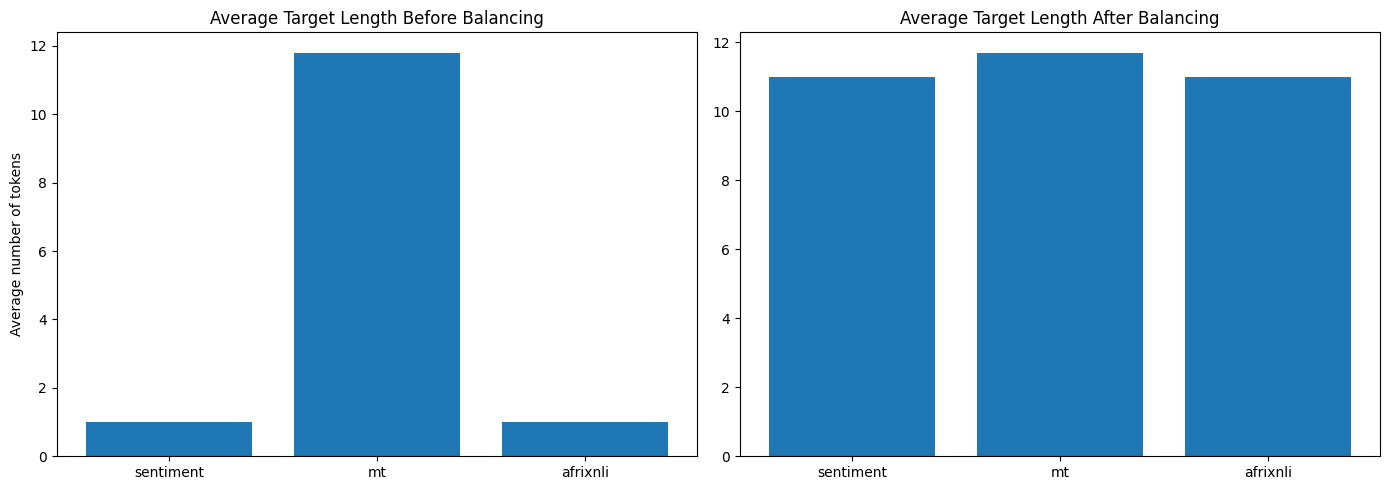

In [31]:
plot_target_lengths(train_df, balanced_df)

Set up model and tokenizer

In [32]:
print("\n# Setting up model with QLoRA")
model_name = "lelapa/InkubaLM-0.4B"
model, tokenizer, bnb_config = setup_model_and_tokenizer(model_name)



# Setting up model with QLoRA


config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/960 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/991k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Apply LoRA adapters

In [33]:
model = apply_lora_adapters(model)

trainable params: 786,432 || all params: 664,946,688 || trainable%: 0.1183


### First approach: Train with unbalanced dataset (to demonstrate the problem)

### Second approach: Train with balanced dataset (the solution)

In [34]:
balanced_trainer = setup_trainer(
    model=model, 
    dataset=balanced_dataset,
    tokenizer=tokenizer,
    output_dir="./sft_model/balanced"
)
balanced_trainer.train()

Applying formatting function to train dataset:   0%|          | 0/18861 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/18861 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/18861 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/18861 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/18861 [00:00<?, ? examples/s]

Step,Training Loss
10,2.313600
20,1.729500
30,2.031200
40,1.907000
50,1.472100
60,1.112900
70,0.901900
80,0.902100
90,1.128300
100,1.100200


TrainOutput(global_step=7074, training_loss=0.6188578942771142, metrics={'train_runtime': 2176.1016, 'train_samples_per_second': 26.002, 'train_steps_per_second': 3.251, 'total_flos': 3.4991236848513024e+16, 'train_loss': 0.6188578942771142})

In [35]:
type(balanced_dataset)

datasets.arrow_dataset.Dataset

### Inference

#### unbalanced model

Load base model in 4-bit mode for inference

In [41]:
adapter_path = "/kaggle/working/sft_model/balanced/checkpoint-7074"
inference_model, inference_tokenizer, _ = setup_model_and_tokenizer(model_name)
inference_model = PeftModel.from_pretrained(inference_model, adapter_path)
inference_model.eval()
results_df = apply_inference_to_test_data(inference_model, inference_tokenizer, test_dataset)
results_df[['ID', 'Response']].to_csv('submission_balanced.csv', index=False)
results_df[['ID', 'generated','Response']].head()

Process Process-auto_conversion:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/safetensors_conversion.py", line 84, in auto_conversion
    sha = get_conversion_pr_reference(api, pretrained_model_name_or_path, **cached_file_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/safetensors_conversion.py", line 71, in get_conversion_pr_reference
    spawn_conversion(token, private, model_id)
  File "/usr/local/lib/python3.10/dist-packages/transformers/safetensors_conversion.py", line 53, in spawn_conversion
    start(sse_connection)
  File "/usr/local/lib/python3.10/dist-packages/transformers/safetensors_conversion.py", line 30, in start
    for line in _sse_connection.iter_lines():
  File "/usr/local/lib/python3

KeyboardInterrupt: 

### Unbalanced model: LB score 0.189

In [37]:
mask = results_df.ID.apply(lambda x: 'sentiment' in x)
print(mask.sum())
results_df.loc[mask, 'Response'].value_counts() 

300


Response
1    174
0     70
2     56
Name: count, dtype: int64

### Balanced model: LB score 0.292

#### balanced model

In [38]:
test_dataset[0]

{'ID': 'ID_f3c74c7b_sentiment_test__hausa',
 'task': 'sentiment',
 'langs': 'hausa',
 'data_source': 'afrisenti',
 'instruction': "Gano ra'ayin da aka bayyana a cikin wannan rubutu. Bin waɗannan jagororin, kyakkyawa yana na rubutu na nufin kyakkyawan tunani, ɗabi'a, da motsin rai. Korau na nuna rubutu na nufin mummunan tunani ko motsin rai. Tsaka-tsaki na nuna rubutu baya nufin magana mai kyau ko mara kyau kai tsaye ko a kaikaice.",
 'inputs': '@user ynxu fha da kanada kudi shikenan duk kayan nan zasu iya zama naka no🧢',
 'targets': None,
 'premise': ''}

In [40]:
mask = results_df.ID.apply(lambda x: 'afrixnli' in x)
print(mask.sum())
results_df.loc[mask, 'Response'].value_counts() 

300


Response
1    133
2     86
0     81
Name: count, dtype: int64

# Conclusion

## Without the fix:
- Tasks with longer outputs (MT) would dominate the loss function
- Model would prioritize performance on MT at the expense of sentiment and XNLI tasks
- This is because SFTTrainer optimizes for per-token loss, not per-sample loss

## With the fix:
- By repeating shorter outputs, we balance the contribution of each task to the loss
- All tasks receive approximately equal weighting in training
- This leads to better overall performance across all tasks

This approach is especially important for multi-task training when tasks have
significantly different output length distributions.